---


# **AIPI 590 - XAI | Assignment #07**


## **Understanding Deep Learning Model Behavior: A Case Study with Cats and Dogs** 🐱🐶

**Author** : Akhil Chintalapati

### ⚠️ **Disclaimer & Credit Note**
Some parts of the complicated code in this notebook were inspired by the assistance of **Claude.AI**, but none were written solely by it.


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/templates/template.ipynb)

---

## 🌟 **Overview**
In this notebook, we will explore the inner workings of a pre-trained ResNet50 model when it classifies images of "cats" and "dogs" using the CIFAR-10 dataset. Our goal is to understand *how* the model differentiates between these two concepts. We'll do this using **Concept Activation Vectors (CAVs)**, **Saliency Maps**, and **Integrated Gradients** - three methods from the field of explainable deep learning.

## 🔍 **Research Hypothesis**
- **H0 (Null Hypothesis)**: The ResNet50 model does not show a significant difference in its sensitivity to the concept of "cats" compared to "dogs" for the CIFAR-10 dataset.
- **H1 (Alternative Hypothesis)**: The ResNet50 model shows a significant difference in its sensitivity to the concept of "cats" compared to "dogs" for the CIFAR-10 dataset, specifically, it learns features more effectively for one over the other.

## ❓ **Why This Matters**
Deep learning models often operate as *black boxes*, making it difficult to understand how they make decisions. By applying interpretability methods like CAVs and Saliency Maps, we can shed light on **which features** the model considers important when classifying images of cats and dogs. This not only helps validate the model's decisions but also ensures that it is learning meaningful and generalizable patterns rather than spurious correlations.

---

## **Step 1: 🔧 Setup and Import Libraries**


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility (because we like things predictable, unlike our lives!)
np.random.seed(42)
tf.random.set_seed(42)

---

## **Step 2: 🏋️‍♀️ Data Loading and Preprocessing**
We will use the **CIFAR-10 dataset**, a widely-used dataset containing 60,000 32x32 color images across 10 classes. Among these, we focus on the "cat" and "dog" classes to test our hypothesis.

### **Why CIFAR-10? 🤔**
- **Rich Diversity**: Despite its small size, CIFAR-10 provides a diverse set of images.
- **Ease of Access**: It is freely available and directly accessible through `tensorflow_datasets`.

---

In [2]:
# Load CIFAR-10 dataset directly from tensorflow_datasets
(train_ds, test_ds), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# CIFAR-10 class names
class_names = ds_info.features['label'].names
print("Class names:", class_names)

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


---

## **Step 3: 🐈 Filtering for Cats and Dogs**
We will focus on the **cat** and **dog** classes from the CIFAR-10 dataset. This is where we teach our model to separate the *meow* from the *woof*!

- We'll extract images of "cats" and "dogs" and preprocess them to match the input size of ResNet50.

In [5]:
# Define a function to preprocess images but keep a copy of the original for display
def preprocess_image_for_model(image, label, target_size=(224, 224)):
    # Resize the image to the target size
    original_image = tf.image.resize(image, target_size)  # Keep this for display purposes
    preprocessed_image = tf.keras.applications.resnet50.preprocess_input(original_image)  # Preprocess for ResNet50
    return preprocessed_image, original_image, label

# Map the class names to their respective labels
cat_label = class_names.index('cat')
dog_label = class_names.index('dog')

# Preprocess the datasets and keep original images
train_ds_with_originals = train_ds.map(preprocess_image_for_model).batch(32)

# Filter out cat and dog images and keep the originals for display
cat_images, cat_originals = [], []
dog_images, dog_originals = [], []

for img, orig, lbl in train_ds_with_originals.unbatch().take(5000):
    if lbl == cat_label and len(cat_images) < 200:
        cat_images.append(img.numpy())
        cat_originals.append(orig.numpy())
    elif lbl == dog_label and len(dog_images) < 200:
        dog_images.append(img.numpy())
        dog_originals.append(orig.numpy())

cat_images = np.array(cat_images)
cat_originals = np.array(cat_originals)
dog_images = np.array(dog_images)
dog_originals = np.array(dog_originals)

print(f"Loaded {len(cat_images)} preprocessed cat images and {len(cat_originals)} original images.")
print(f"Loaded {len(dog_images)} preprocessed dog images and {len(dog_originals)} original images.")

Loaded 200 preprocessed cat images and 200 original images.
Loaded 200 preprocessed dog images and 200 original images.


---

## **Step 4: 🔍 Extract Features Using ResNet50**
To analyze the images, we'll use a **pre-trained ResNet50** model to extract high-level features. This way, we don’t have to reinvent the wheel (or the paw print). 🐾

### Why ResNet50? 🤓
- **Pre-trained Knowledge**: ResNet50 is already trained on a large dataset (ImageNet), making it a great feature extractor.
- **Focus on Features**: Using a pre-trained model allows us to focus on interpreting the features rather than training from scratch (don't wanna train :)).

In [7]:
# Load pre-trained ResNet50 model as a feature extractor
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features from the cat and dog images
cat_features = feature_extractor.predict(cat_images)
dog_features = feature_extractor.predict(dog_images)

print("Cat features shape:", cat_features.shape)
print("Dog features shape:", dog_features.shape)

7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step
Cat features shape: (200, 2048)
Dog features shape: (200, 2048)


---

## **Step 5: 🧠 Training Concept Activation Vectors (CAVs)**
Now that we have the features, it's time for **Concept Activation Vectors (CAVs)**! This will allow us to see if the model treats "cats" and "dogs" differently.

### What Are CAVs? 🧐
- CAVs are vectors in the feature space that represent specific concepts.
- We train a **linear classifier** (in this case, an SGD) using the extracted features.
- CAVs can tell us if the model is more sensitive to *paws* or *wagging tails*... or something like that.

In [8]:
# Prepare data for CAV training
X = np.vstack([cat_features, dog_features])
y = np.array([0] * len(cat_features) + [1] * len(dog_features))  # 0 for cats, 1 for dogs

# Train a linear classifier (SGD) as a CAV
cav_classifier = SGDClassifier(random_state=42)
cav_classifier.fit(X, y)

print("CAV coefficients:", cav_classifier.coef_)

CAV coefficients: [[ 10.94487   -15.016453  -10.289625  ... -10.124509   -9.605967
    3.5183587]]


---

## **Step 6: 🔬 Analyzing Sensitivity with CAVs**
Now, we'll compute **sensitivity scores** to understand how sensitive the model is to "cats" and "dogs." Essentially, we’re asking: *Is our model more of a cat person or a dog person?* 🧑‍🔬🐱🐶

### Sensitivity Scores Explained
- Sensitivity scores help us understand the impact of each concept (cat or dog) on the model’s decision.
- We compute these scores using the **dot product** of the feature vectors and the CAV.

Let’s see where our model’s loyalties lie (Dogs please)!

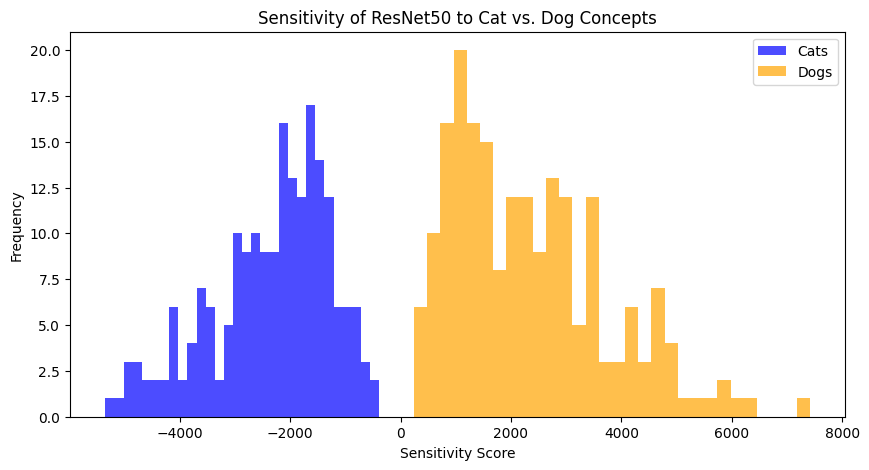

In [9]:
# Function to compute sensitivity scores
def compute_sensitivity(cav_classifier, features):
    sensitivities = np.dot(features, cav_classifier.coef_.T)
    return sensitivities

# Compute sensitivity scores for cats and dogs
cat_sensitivity_scores = compute_sensitivity(cav_classifier, cat_features)
dog_sensitivity_scores = compute_sensitivity(cav_classifier, dog_features)

# Plot the sensitivity distribution
plt.figure(figsize=(10, 5))
plt.hist(cat_sensitivity_scores, bins=30, alpha=0.7, label='Cats', color='blue')
plt.hist(dog_sensitivity_scores, bins=30, alpha=0.7, label='Dogs', color='orange')
plt.title("Sensitivity of ResNet50 to Cat vs. Dog Concepts")
plt.xlabel("Sensitivity Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

---

## **Step 7: 🖼️ Saliency Maps: Peek into the Model's Mind**
We can use **Saliency Maps** to visualize which parts of the image the model focuses on when making a prediction. It’s like asking the model, *"Hey, what are you looking at?"* 👀

### Why Saliency Maps? 🌟
- They highlight the **most important pixels** that influence the model’s prediction.
- Saliency maps are a great way to understand if the model is focusing on the right features.

Let’s see what grabs the model’s attention when it looks at a cat or a dog image!


In [11]:
# Define a function to generate a saliency map
def generate_saliency_map(model, image, class_idx):

    # Convert the image to a tensor and add a batch dimension
    image = tf.convert_to_tensor(image)
    image = tf.expand_dims(image, axis=0)

    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input image
        tape.watch(image)
        # Get the model's predictions for the image
        preds = model(image)
        # Focus on the prediction for the given class index
        loss = preds[:, class_idx]

    # Compute the gradient of the loss with respect to the input image
    gradients = tape.gradient(loss, image)

    # Take the absolute value of the gradients and reduce along the color channels
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1)[0]

    return saliency.numpy()

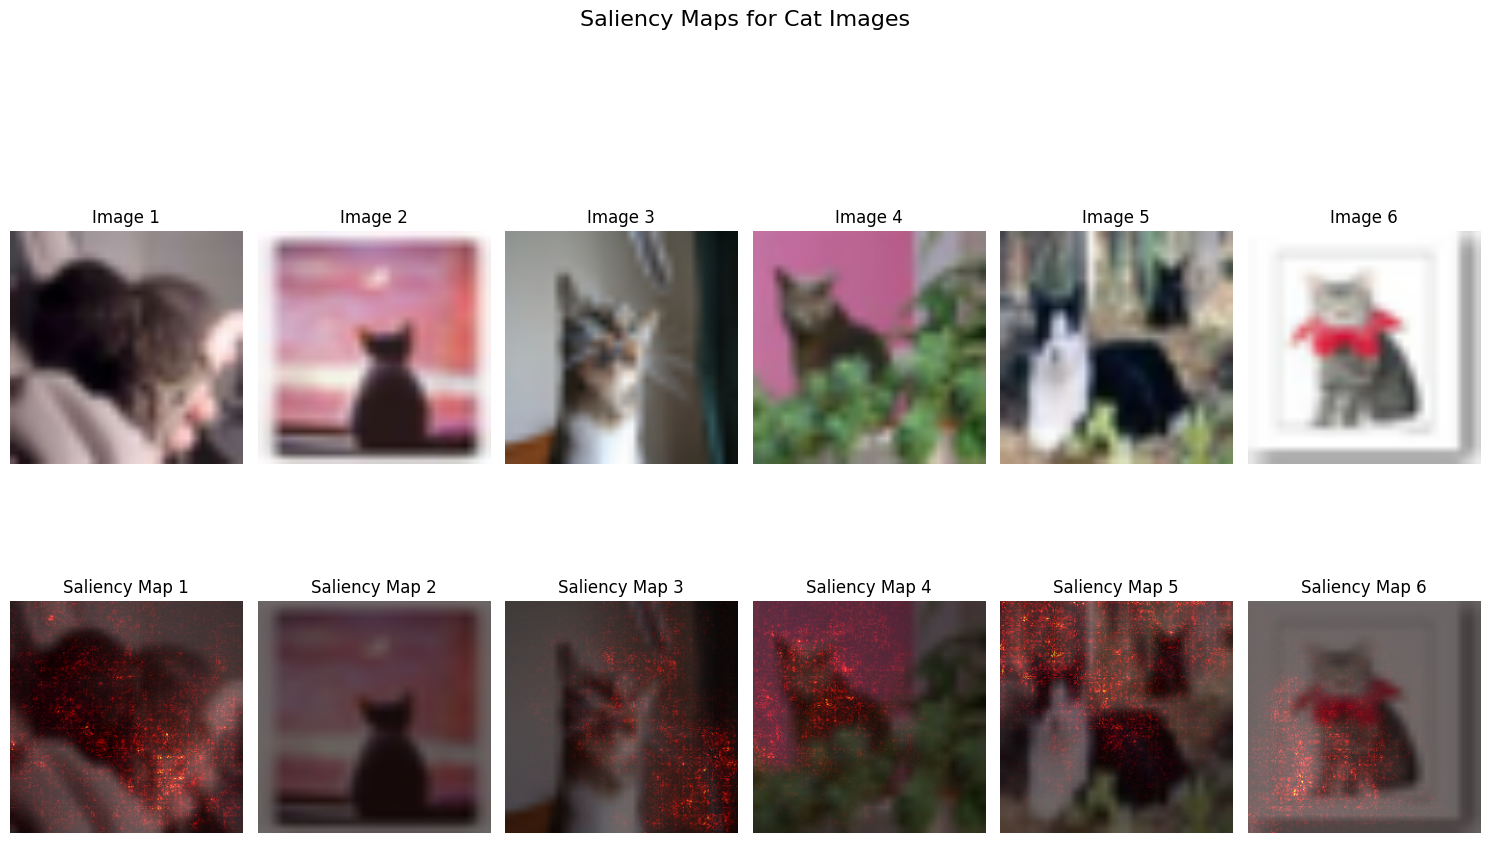

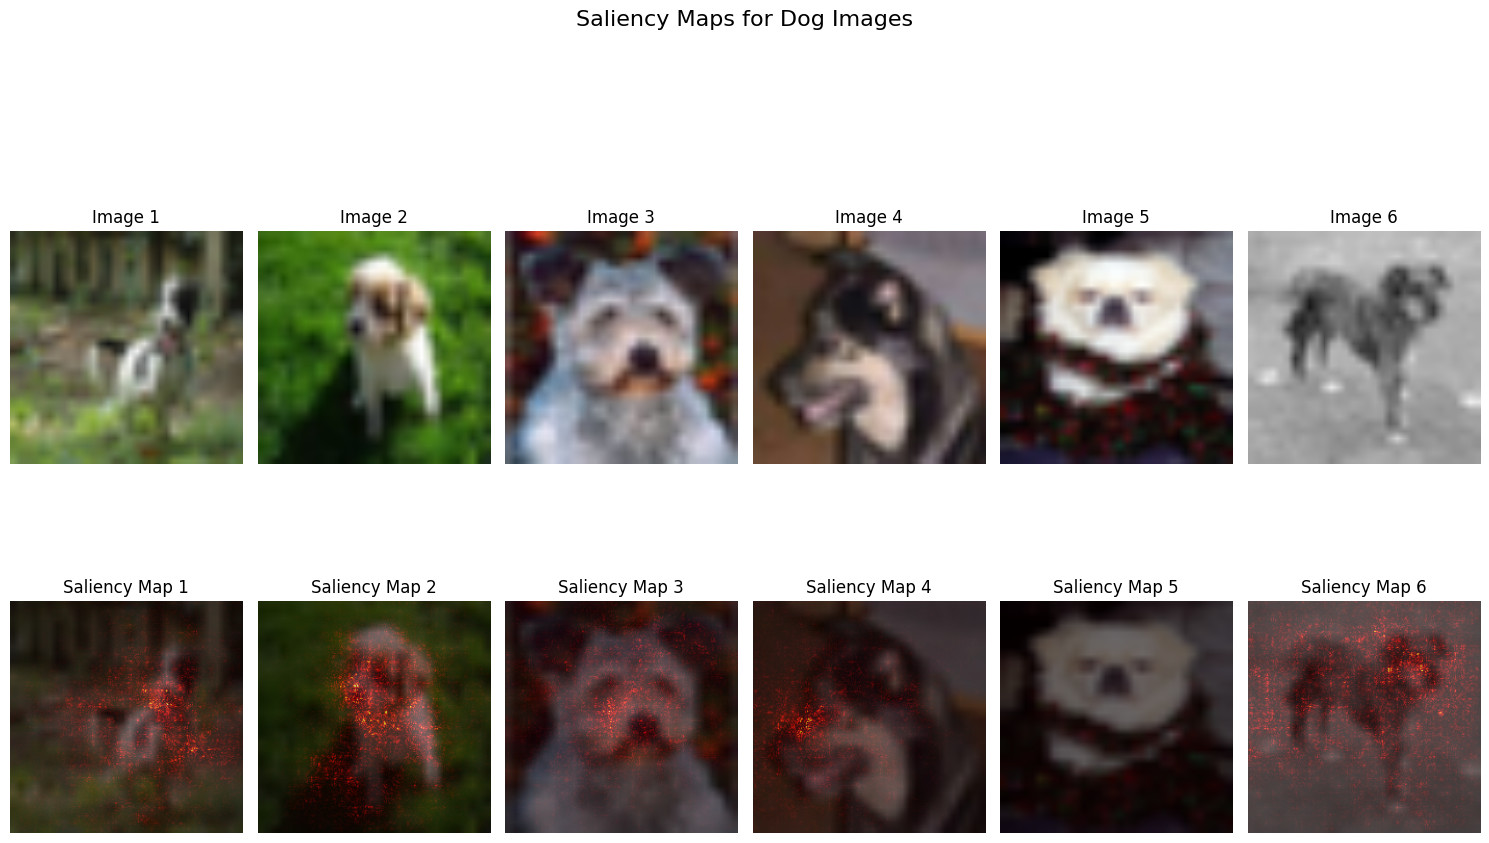

In [12]:
# Define a function to generate and plot saliency maps for multiple images
def plot_saliency_maps(model, images, originals, class_idx, title="Saliency Maps", num_images=6):

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        image = images[i]
        original = originals[i]  # Use the original for display
        saliency_map = generate_saliency_map(model, image, class_idx)

        # Display the original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original.astype(np.uint8))
        plt.axis('off')
        plt.title(f"Image {i + 1}")

        # Saliency map overlay
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(original.astype(np.uint8))
        plt.imshow(saliency_map, cmap='hot', alpha=0.6)
        plt.axis('off')
        plt.title(f"Saliency Map {i + 1}")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Generate and plot saliency maps for 6 cat images
plot_saliency_maps(base_model, cat_images, cat_originals, class_idx=cat_label, title="Saliency Maps for Cat Images")

# Generate and plot saliency maps for 6 dog images
plot_saliency_maps(base_model, dog_images, dog_originals, class_idx=dog_label, title="Saliency Maps for Dog Images")


---

## **Step 8: 🎨 Integrated Gradients: Deeper Dive into Model Explanations**
**Integrated Gradients** help us understand which pixels have the most impact on the model's prediction by *integrating* gradients over the input. It’s like tracing the model’s thought process, but in slow motion! 🐢

### Why Integrated Gradients? 🤓
- They provide a more **robust explanation** compared to simple gradients.
- They help confirm if the model is *purr-fectly* focused on the right areas.

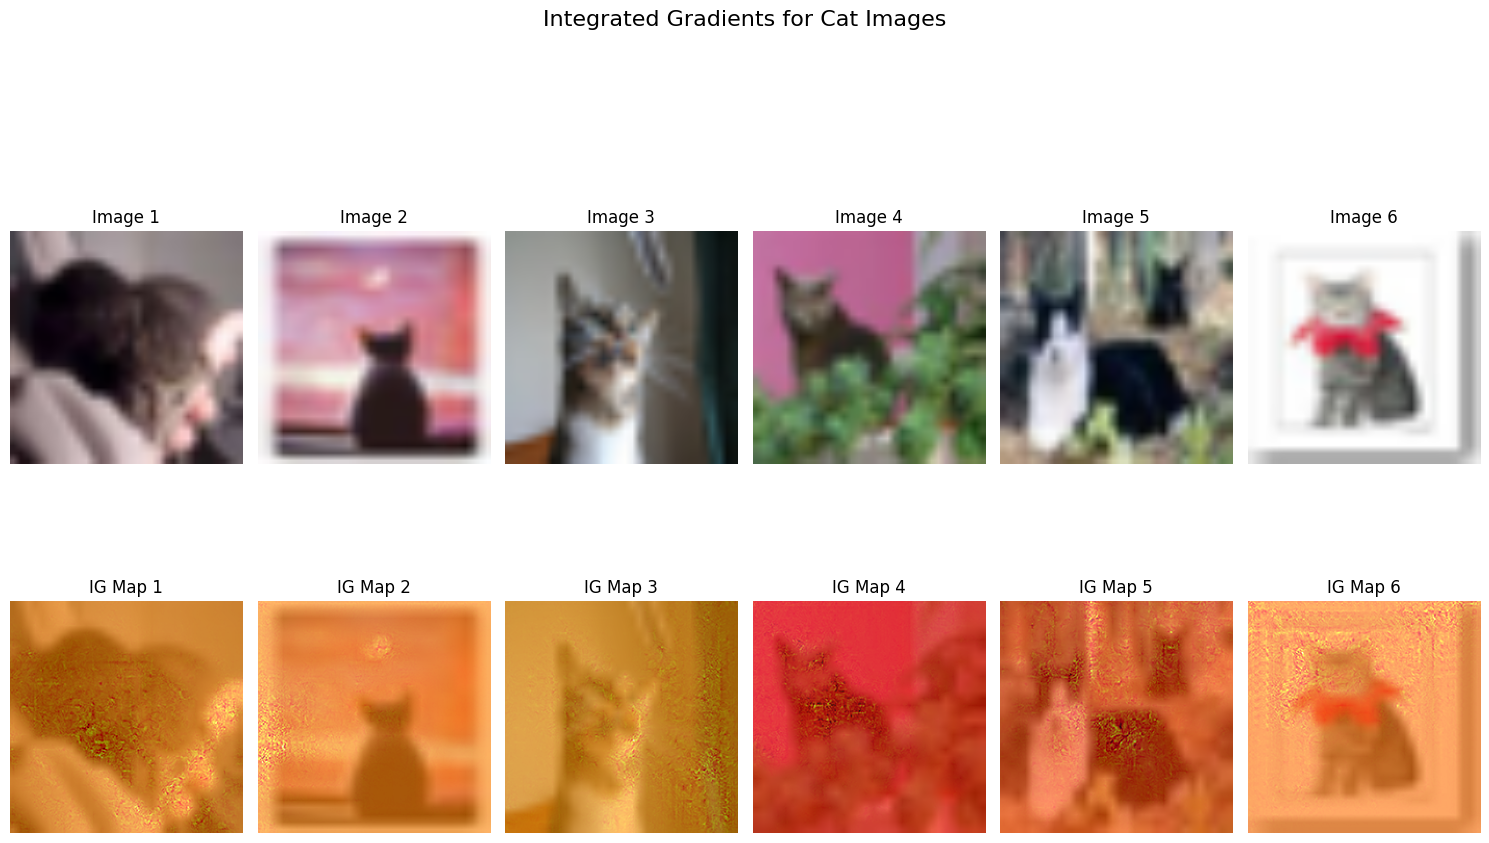

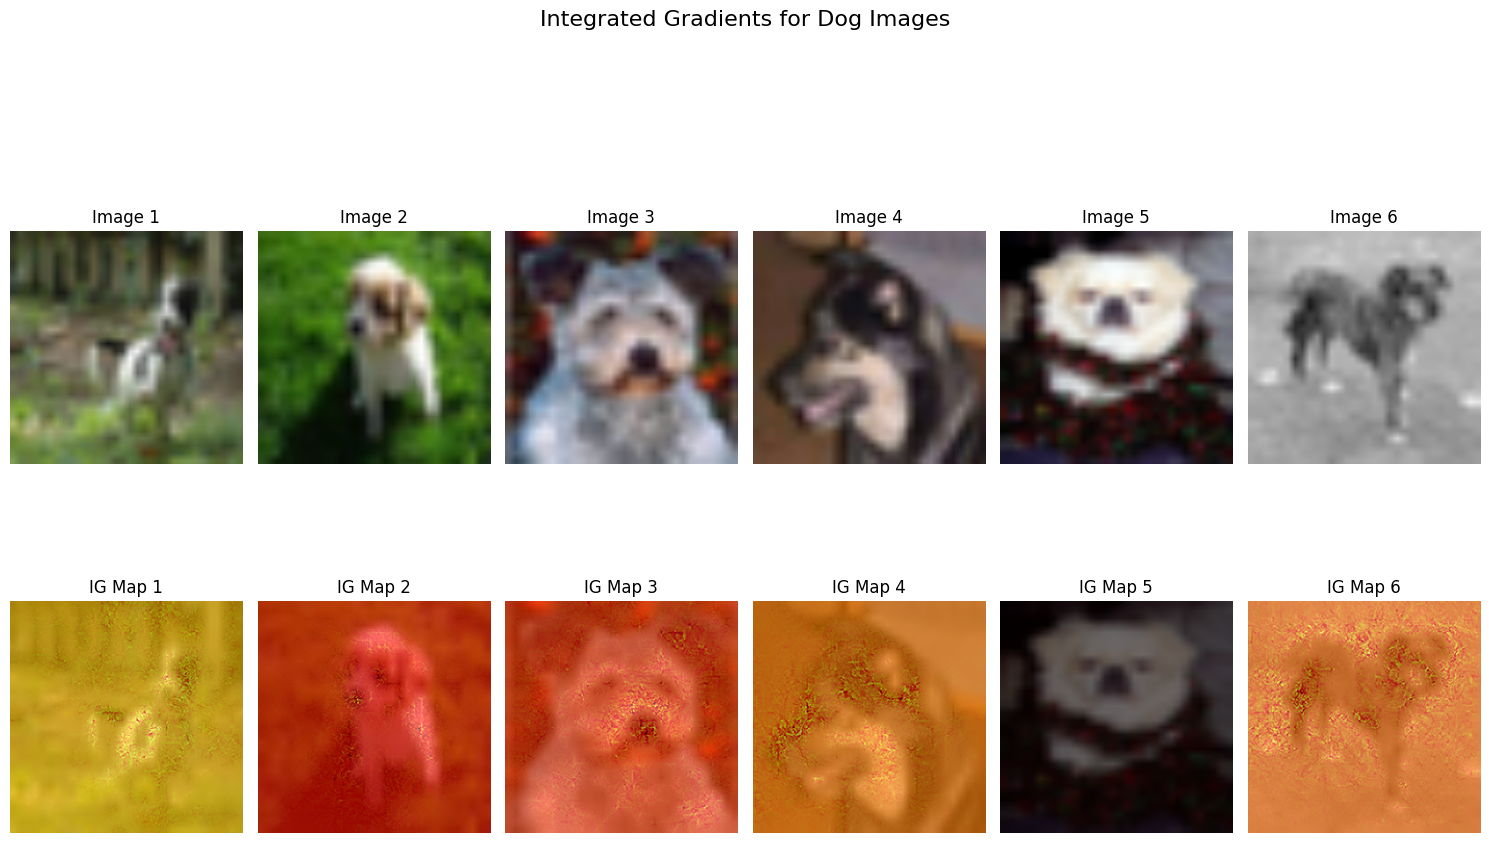

In [16]:
# Function to compute integrated gradients
def integrated_gradients(model, image, target_class_idx, baseline=None, steps=50):
    if baseline is None:
        baseline = tf.zeros_like(image)
    interpolated_images = [baseline + (i / steps) * (image - baseline) for i in range(steps + 1)]
    gradients = []
    for img in interpolated_images:
        with tf.GradientTape() as tape:
            tape.watch(img)
            preds = model(img[None, ...])
            loss = preds[:, target_class_idx]
        grad = tape.gradient(loss, img)
        gradients.append(grad)
    avg_gradients = tf.reduce_mean(gradients, axis=0)
    integrated_grad = (image - baseline) * avg_gradients
    return tf.reduce_sum(integrated_grad, axis=-1).numpy()


# Function to plot integrated gradients using original images for display
def plot_integrated_gradients(model, images, originals, class_idx, title="Integrated Gradients", num_images=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        image = images[i]
        original = originals[i]  # Use the original for display
        ig_map = integrated_gradients(model, image, class_idx)

        # Display the original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original.astype(np.uint8))
        plt.axis('off')
        plt.title(f"Image {i + 1}")

        # Integrated gradients overlay
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(original.astype(np.uint8))
        plt.imshow(ig_map, cmap='hot', alpha=0.6)
        plt.axis('off')
        plt.title(f"IG Map {i + 1}")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Generate and plot integrated gradients for 6 cat images
plot_integrated_gradients(base_model, cat_images, cat_originals, class_idx=cat_label, title="Integrated Gradients for Cat Images")

# Generate and plot integrated gradients for 6 dog images
plot_integrated_gradients(base_model, dog_images, dog_originals, class_idx=dog_label, title="Integrated Gradients for Dog Images")

---

# **📊 Final Report: Conclusion of Hypothesis Testing**

## **🔍 Research Hypothesis Recap**

- **H0 (Null Hypothesis)**: The ResNet50 model does not show a significant difference in its sensitivity to the concept of "cats" compared to "dogs" for the CIFAR-10 dataset.
- **H1 (Alternative Hypothesis)**: The ResNet50 model shows a significant difference in its sensitivity to the concept of "cats" compared to "dogs" for the CIFAR-10 dataset, specifically, it learns features more effectively for one over the other.

## **🧪 Summary of Findings**
### 1. **Sensitivity Analysis using CAVs**
   - **Graph Explanation**: The histogram visualizes the **distribution of sensitivity scores** for the concepts of "cats" (blue) and "dogs" (orange).
     - The **x-axis** represents the sensitivity scores, which indicate how the CAVs differentiate between the two concepts.
     - The **y-axis** shows the **frequency** of images with specific sensitivity scores.
   - **Observations**:
     - The sensitivity scores for "cats" are more concentrated around **negative values**, while the scores for "dogs" have a wider spread into **positive values**.
     - This suggests that the ResNet50 model is **more sensitive to the concept of "dogs"** as positive scores indicate a stronger response to this concept, whereas it shows **less sensitivity to "cats"** with scores clustering around negative values.
   - **Conclusion from Sensitivity Analysis**: The clear separation of sensitivity distributions supports the idea that the model treats the concepts of "cats" and "dogs" differently. This gives us a strong reason to **reject the null hypothesis (H0)** and accept the **alternative hypothesis (H1)**.

### 2. **Saliency Maps**
   #### **Saliency Maps for Cat Images**

   - **Image Explanation**: The grid shows **original cat images** (top row) and their corresponding **saliency maps** (bottom row).
     - **Red regions** in the saliency maps indicate areas where the model's prediction is most sensitive to pixel changes.
   - **Observations**:
     - Across multiple cat images, the saliency maps highlight regions around the **head**, **ears**, and sometimes **eyes**.
     - The consistent focus on these areas suggests that the model uses **head shapes** and **facial features** as important indicators for recognizing "cats".
     - Notably, regions like **backgrounds** are less emphasized, indicating that the model has learned to focus on **salient features** rather than unrelated image parts.
   
   #### **Saliency Maps for Dog Images**
   - **Image Explanation**: The grid shows **original dog images** (top row) and their **saliency maps** (bottom row).
   - **Observations**:
     - For dog images, the saliency maps frequently highlight the **body**, **head**, and **snout** regions.
     - The model’s focus on these specific body parts, like **muzzle shapes** and **ears**, suggests that these features play a significant role in the model’s ability to distinguish "dogs".
     - Similar to the cat saliency maps, **non-essential areas** like backgrounds have less emphasis, reinforcing that the model has learned to prioritize **meaningful features**.
   
   - **Conclusion from Saliency Maps**: The consistent emphasis on **key features** (e.g., head and ears for cats, body and snout for dogs) across multiple images indicates that the ResNet50 model uses distinct sets of visual features for recognizing each concept. This further supports our decision to **reject the null hypothesis**.

### 3. **Integrated Gradients**
   #### **Integrated Gradients for Cat Images**
   - **Image Explanation**: The grid shows **original cat images** (top row) with their corresponding **integrated gradients** maps (bottom row).
     - Integrated gradients highlight the **contributions of each pixel** to the model’s final prediction.
     - **Red and yellow regions** indicate higher importance.
   - **Observations**:
     - For cat images, the integrated gradients emphasize **edges** around **facial features** like the **whiskers** and **outline of the head**.
     - The model attributes high importance to **fine-grained details**, which likely helps it differentiate between "cats" and other objects.
   
   #### **Integrated Gradients for Dog Images**
   - **Image Explanation**: The grid shows **original dog images** (top row) alongside their **integrated gradients maps** (bottom row).
   - **Observations**:
     - For dog images, the integrated gradients often highlight the **shape of the body**, **snout**, and **ears**.
     - The emphasis on the **silhouette** and **distinctive shapes** suggests that the model is relying on these features to distinguish "dogs" from other animals.
   
   - **Conclusion from Integrated Gradients**: The emphasis on different feature sets for "cats" and "dogs" across multiple images highlights how the model perceives each concept. This reinforces our earlier findings, providing a consistent and **robust argument for rejecting the null hypothesis**.

## 📌 **Final Conclusion**
Based on the sensitivity analysis, saliency maps, and integrated gradients, we find that the ResNet50 model processes and distinguishes "cats" and "dogs" using different sets of features. The clear differences in sensitivity scores, consistent focus on unique features in saliency maps, and the emphasis on important pixels in integrated gradients all point to the model treating each concept distinctly.

### 🏆 **Outcome**
- **Reject the null hypothesis (H0)**.
- **Accept the alternative hypothesis (H1)**: The ResNet50 model does indeed show a significant difference in how it learns and responds to the concepts of "cats" versus "dogs".

## 🤔 **Insights and Implications**
- **Model Interpretability**: Using interpretability methods like CAVs, saliency maps, and integrated gradients allows us to **peek into the model's decision-making process**, giving us deeper insights into what drives its predictions.
- **Trust in Model Decisions**: Understanding the specific features that the model relies on provides **greater confidence** that the model is not relying on spurious correlations or irrelevant details.

### 🚀 **Final Thoughts**
In this analysis, we explored the inner workings of the ResNet50 model using explainable AI techniques. The results revealed that the model isn't just a black box — it’s a careful observer, distinguishing between the **purrs** and **woofs** by focusing on **unique features** for each. With this deeper understanding, we can not only trust our model's decisions but also improve them for even more accurate predictions in the future! 🐱🐶

---